In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

## Read in Data

In [2]:
T_nc = Dataset('../Data/climate/tmp.0-10cm.mon.ltm.nc')
R_nc = Dataset('../Data/climate/runof.sfc.mon.ltm.nc')
P_nc = Dataset('../Data/climate/prate.sfc.mon.ltm.nc')
E_nc = Dataset('../Data/climate/pevpr.sfc.mon.ltm.nc')
ls_nc = Dataset('../Data/climate/lsmask.19294.nc')

-1 is land, and 0 is ocean.

## Get Annual Zonal Means

In [3]:
T_zonal_means_nc = np.array([])
R_zonal_means_nc = np.array([])
P_zonal_means_nc = np.array([])
E_zonal_means_nc = np.array([])

for i in range(len(T_nc.variables['lat'])):
    year_T = np.array([])
    year_R = np.array([])
    year_P = np.array([])
    year_E = np.array([])
    
    for j in range(len(T_nc.variables['time'])):
        data_T = T_nc.variables['tmp'][j,i,:].data
        data_T = data_T[data_T>-100]
        data_R = R_nc.variables['runof'][j,i,:].data
        data_R = data_R[data_R>-100]
        data_P = P_nc.variables['prate'][j,i,:].data
        data_P = data_P[data_P>-100]
        data_E = E_nc.variables['pevpr'][j,i,:].data
        data_E = data_E[data_E>-100]
        
        year_T = np.append(year_T, data_T)
        year_R = np.append(year_R, data_R)
        year_P = np.append(year_P, data_P)
        year_E = np.append(year_E, data_E)
        
    T_zonal_means_nc = np.append(T_zonal_means_nc, np.nanmean(year_T))
    R_zonal_means_nc = np.append(R_zonal_means_nc, np.nanmean(year_R))
    P_zonal_means_nc = np.append(P_zonal_means_nc, np.nanmean(year_P))
    E_zonal_means_nc = np.append(E_zonal_means_nc, np.nanmean(year_E))

Convert units to C and m/yr:

In [4]:
T_zonal_means = T_zonal_means_nc - 273.15
P_zonal_means = P_zonal_means_nc * 31536000 * 0.001

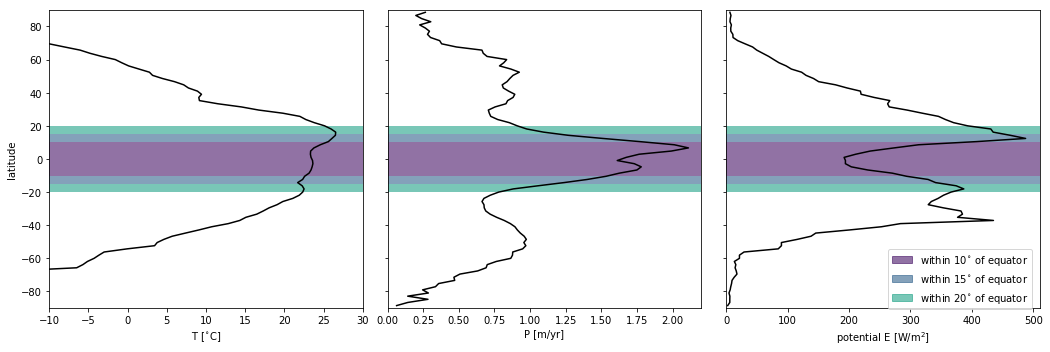

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15,5))

degrees_10 = patches.Rectangle((-10,-10),520,20,edgecolor='none',alpha=0.6,facecolor='#481567')
degrees_15_low = patches.Rectangle((-10,-15),520,5,edgecolor='none',alpha=0.6,facecolor='#33638D')
degrees_15_high = patches.Rectangle((-10,10),520,5,edgecolor='none',alpha=0.6,facecolor='#33638D')
degrees_20_low = patches.Rectangle((-10,-20),520,5,edgecolor='none',alpha=0.6,facecolor='#20A387')
degrees_20_high = patches.Rectangle((-10,15),520,5,edgecolor='none',alpha=0.6,facecolor='#20A387')
ax[0].add_patch(degrees_10)
ax[0].add_patch(degrees_15_low)
ax[0].add_patch(degrees_15_high)
ax[0].add_patch(degrees_20_low)
ax[0].add_patch(degrees_20_high)
ax[0].plot(T_zonal_means,T_nc.variables['lat'],color='black')
ax[0].set_xlabel('T [$^{\circ}$C]')
ax[0].set_ylim([-90, 90])
ax[0].set_xlim([-10,30])
ax[0].set_ylabel('latitude')

degrees_10 = patches.Rectangle((-10,-10),520,20,edgecolor='none',alpha=0.6,facecolor='#481567')
degrees_15_low = patches.Rectangle((-10,-15),520,5,edgecolor='none',alpha=0.6,facecolor='#33638D')
degrees_15_high = patches.Rectangle((-10,10),520,5,edgecolor='none',alpha=0.6,facecolor='#33638D')
degrees_20_low = patches.Rectangle((-10,-20),520,5,edgecolor='none',alpha=0.6,facecolor='#20A387')
degrees_20_high = patches.Rectangle((-10,15),520,5,edgecolor='none',alpha=0.6,facecolor='#20A387')
ax[1].add_patch(degrees_10)
ax[1].add_patch(degrees_15_low)
ax[1].add_patch(degrees_15_high)
ax[1].add_patch(degrees_20_low)
ax[1].add_patch(degrees_20_high)
ax[1].plot(P_zonal_means,T_nc.variables['lat'],color='black')
ax[1].set_xlabel('P [m/yr]')
ax[1].set_ylim([-90, 90])
ax[1].set_xlim([0, 2.2])

degrees_10 = patches.Rectangle((-10,-10),520,20,edgecolor='none',alpha=0.6,facecolor='#481567')
degrees_15_low = patches.Rectangle((-10,-15),520,5,edgecolor='none',alpha=0.6,facecolor='#33638D')
degrees_15_high = patches.Rectangle((-10,10),520,5,edgecolor='none',alpha=0.6,facecolor='#33638D')
degrees_20_low = patches.Rectangle((-10,-20),520,5,edgecolor='none',alpha=0.6,facecolor='#20A387')
degrees_20_high = patches.Rectangle((-10,15),520,5,edgecolor='none',alpha=0.6,facecolor='#20A387')
ax[2].add_patch(degrees_10)
ax[2].add_patch(degrees_15_low)
ax[2].add_patch(degrees_15_high)
ax[2].add_patch(degrees_20_low)
ax[2].add_patch(degrees_20_high)
ax[2].plot(E_zonal_means_nc,T_nc.variables['lat'],color='black')
ax[2].set_xlabel('potential E [W/m$^{2}$]')
ax[2].set_ylim([-90, 90])
ax[2].set_xlim([0,510])

degrees_10 = patches.Patch(linestyle='-', label='within 10$^{\circ}$ of equator',color='#481567',alpha=0.6)
degrees_15 = patches.Patch(label='within 15$^{\circ}$ of equator',color='#33638D',alpha=0.6)
degrees_20 = patches.Patch(label='within 20$^{\circ}$ of equator',color='#20A387',alpha=0.6)
plt.legend(ncol=1,bbox_to_anchor=(0.5, -.02),handles=[degrees_10,degrees_15,degrees_20],loc='lower left')

plt.tight_layout()
plt.show(fig)

## Land Data Only

Note that T, R, and P data is already over land only, except it includes seasonally variable ice sheets:

In [6]:
Tland_zonal_means_nc = np.array([])
Rland_zonal_means_nc = np.array([])
Pland_zonal_means_nc = np.array([])
Eland_zonal_means_nc = np.array([])

for i in range(len(T_nc.variables['lat'])):
    year_T = np.array([])
    year_R = np.array([])
    year_P = np.array([])
    year_E = np.array([])
    
    for j in range(len(T_nc.variables['time'])):
        data_T = T_nc.variables['tmp'][j,i,:].data[ls_nc.variables['lsmask'][0,i,:].data==-1]
        data_T = data_T[data_T>-100]
        data_R = R_nc.variables['runof'][j,i,:].data[ls_nc.variables['lsmask'][0,i,:].data==-1]
        data_R = data_R[data_R>-100]
        data_P = P_nc.variables['prate'][j,i,:].data[ls_nc.variables['lsmask'][0,i,:].data==-1]
        data_P = data_P[data_P>-100]
        data_E = E_nc.variables['pevpr'][j,i,:].data[ls_nc.variables['lsmask'][0,i,:].data==-1]
        data_E = data_E[data_E>-100]
        
        year_T = np.append(year_T, data_T)
        year_R = np.append(year_R, data_R)
        year_P = np.append(year_P, data_P)
        year_E = np.append(year_E, data_E)
        
    Tland_zonal_means_nc = np.append(Tland_zonal_means_nc, np.nanmean(year_T))
    Rland_zonal_means_nc = np.append(Rland_zonal_means_nc, np.nanmean(year_R))
    Pland_zonal_means_nc = np.append(Pland_zonal_means_nc, np.nanmean(year_P))
    Eland_zonal_means_nc = np.append(Eland_zonal_means_nc, np.nanmean(year_E))

/Users/yuempark/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
/Users/yuempark/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice
/Users/yuempark/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/Users/yuempark/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice


In [7]:
Tland_zonal_means = Tland_zonal_means_nc - 273.15
Pland_zonal_means = Pland_zonal_means_nc * 31536000 * 0.001

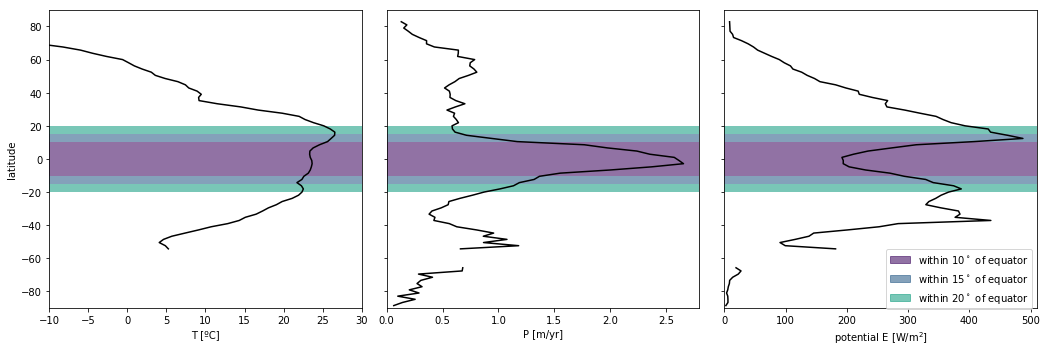

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15,5))

degrees_10 = patches.Rectangle((-10,-10),520,20,edgecolor='none',alpha=0.6,facecolor='#481567')
degrees_15_low = patches.Rectangle((-10,-15),520,5,edgecolor='none',alpha=0.6,facecolor='#33638D')
degrees_15_high = patches.Rectangle((-10,10),520,5,edgecolor='none',alpha=0.6,facecolor='#33638D')
degrees_20_low = patches.Rectangle((-10,-20),520,5,edgecolor='none',alpha=0.6,facecolor='#20A387')
degrees_20_high = patches.Rectangle((-10,15),520,5,edgecolor='none',alpha=0.6,facecolor='#20A387')
ax[0].add_patch(degrees_10)
ax[0].add_patch(degrees_15_low)
ax[0].add_patch(degrees_15_high)
ax[0].add_patch(degrees_20_low)
ax[0].add_patch(degrees_20_high)
ax[0].plot(Tland_zonal_means,T_nc.variables['lat'],color='black')
ax[0].set_xlabel('T [ºC]')
ax[0].set_ylim([-90, 90])
ax[0].set_xlim([-10,30])
ax[0].set_ylabel('latitude')

degrees_10 = patches.Rectangle((-10,-10),520,20,edgecolor='none',alpha=0.6,facecolor='#481567')
degrees_15_low = patches.Rectangle((-10,-15),520,5,edgecolor='none',alpha=0.6,facecolor='#33638D')
degrees_15_high = patches.Rectangle((-10,10),520,5,edgecolor='none',alpha=0.6,facecolor='#33638D')
degrees_20_low = patches.Rectangle((-10,-20),520,5,edgecolor='none',alpha=0.6,facecolor='#20A387')
degrees_20_high = patches.Rectangle((-10,15),520,5,edgecolor='none',alpha=0.6,facecolor='#20A387')
ax[1].add_patch(degrees_10)
ax[1].add_patch(degrees_15_low)
ax[1].add_patch(degrees_15_high)
ax[1].add_patch(degrees_20_low)
ax[1].add_patch(degrees_20_high)
ax[1].plot(Pland_zonal_means,T_nc.variables['lat'],color='black')
ax[1].set_xlabel('P [m/yr]')
ax[1].set_ylim([-90, 90])
ax[1].set_xlim([0, 2.8])

degrees_10 = patches.Rectangle((-10,-10),520,20,edgecolor='none',alpha=0.6,facecolor='#481567')
degrees_15_low = patches.Rectangle((-10,-15),520,5,edgecolor='none',alpha=0.6,facecolor='#33638D')
degrees_15_high = patches.Rectangle((-10,10),520,5,edgecolor='none',alpha=0.6,facecolor='#33638D')
degrees_20_low = patches.Rectangle((-10,-20),520,5,edgecolor='none',alpha=0.6,facecolor='#20A387')
degrees_20_high = patches.Rectangle((-10,15),520,5,edgecolor='none',alpha=0.6,facecolor='#20A387')
ax[2].add_patch(degrees_10)
ax[2].add_patch(degrees_15_low)
ax[2].add_patch(degrees_15_high)
ax[2].add_patch(degrees_20_low)
ax[2].add_patch(degrees_20_high)
ax[2].plot(Eland_zonal_means_nc,T_nc.variables['lat'],color='black')
ax[2].set_xlabel('potential E [W/m$^{2}$]')
ax[2].set_ylim([-90, 90])
ax[2].set_xlim([0,510])

degrees_10 = patches.Patch(linestyle='-', label='within 10$^\circ$ of equator',color='#481567',alpha=0.6)
degrees_15 = patches.Patch(label='within 15$^\circ$ of equator',color='#33638D',alpha=0.6)
degrees_20 = patches.Patch(label='within 20$^\circ$ of equator',color='#20A387',alpha=0.6)
plt.legend(ncol=1,bbox_to_anchor=(0.5, -.02),handles=[degrees_10,degrees_15,degrees_20],loc='lower left')

plt.tight_layout()
plt.show(fig)

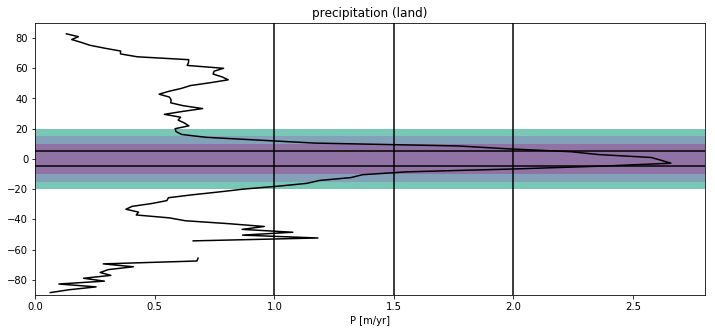

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,5))

degrees_10 = patches.Rectangle((-10,-10),40,20,edgecolor='none',alpha=0.6,facecolor='#481567')
degrees_15_low = patches.Rectangle((-10,-15),40,5,edgecolor='none',alpha=0.6,facecolor='#33638D')
degrees_15_high = patches.Rectangle((-10,10),40,5,edgecolor='none',alpha=0.6,facecolor='#33638D')
degrees_20_low = patches.Rectangle((-10,-20),40,5,edgecolor='none',alpha=0.6,facecolor='#20A387')
degrees_20_high = patches.Rectangle((-10,15),40,5,edgecolor='none',alpha=0.6,facecolor='#20A387')
ax.add_patch(degrees_10)
ax.add_patch(degrees_15_low)
ax.add_patch(degrees_15_high)
ax.add_patch(degrees_20_low)
ax.add_patch(degrees_20_high)
ax.plot(Pland_zonal_means,T_nc.variables['lat'],color='black')
ax.set_xlabel('P [m/yr]')
ax.set_ylim([-90, 90])
ax.set_xlim([0, 2.8])
ax.set_title('precipitation (land)')
plt.vlines(1,-90,90)
plt.vlines(1.5,-90,90)
plt.vlines(2,-90,90)
plt.hlines(-5,0,2.8)
plt.hlines(5,0,2.8)

plt.show(fig)